# Make Clustering Datase
This script creates a dataframe with different features calculated from the original price changes dataframe and the stations dataframe. The goal is to apply clustering methods on this dataset in order to be able to cluster the different kind of stations.

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks
import warnings
warnings.filterwarnings("ignore")
import refuel_tools as rt

## Loading the data

In [2]:
df_stations = pd.read_csv('./tankerkoenig-data/stations/stations.csv')

In [4]:
df = pd.read_pickle("./data/df_FULL_365.pkl", compression='xz')

In [8]:
# There are 6 gas station with Zeros as latitude/longitude, so I will drop those!
df_stations = df_stations[df_stations.latitude != 0]

In [9]:
df_stations.head()

,uuid,name,brand,street,house_number,post_code,city,latitude,longitude
0,00060723-0001-4444-8888-acdc00000001,BAGeno Raiffeisen eG,NaN,Künzelsauer Strasse,7,74653,Ingelfingen,49.296822,9.661385
1,005056ba-7cb6-1ed2-bceb-5332ab168d12,famila Tankstelle,FAMILA,Pascalstrasse,9,25442,Quickborn,53.742150,9.941240
2,005056ba-7cb6-1ed2-bceb-573c18314d16,star Tankstelle,STAR,Riehler Strasse,240,50735,Köln,50.961800,6.980070
3,005056ba-7cb6-1ed2-bceb-662ba1a94d1f,star Tankstelle,STAR,BAB 10 / Seeberg Ost,NaN,15345,Altlandsberg,52.550160,13.682120
4,005056ba-7cb6-1ed2-bceb-6f7b23564d23,star Tankstelle,STAR,Duisburger Straße,130,47166,Duisburg,51.489790,6.783730


In [11]:
# Building a tree from all the given stations
from scipy.spatial import cKDTree
tree = cKDTree(np.c_[df_stations.latitude.ravel(), df_stations.longitude.ravel()])


def n_neighbors_list(position, tree, radius=1):
    """This is a test function of n_neighbors"""
    from scipy.spatial import cKDTree
    from math import pi
    neighbors = tree.query_ball_point([position[0], position[1]], radius/((6371*pi)/180.0))
    # Faktor to transform deg to kilometer
    #r/((6371*pi)/180.0)
    return (len(neighbors)-1), neighbors

In [12]:
df_stations['neighbors_3km'] = df_stations.apply(lambda row: rt.number_of_neighbors(row, tree, radius=3), axis=1)
df_stations['neighbors_5km'] = df_stations.apply(lambda row: number_of_neighbors(row, tree, radius=5), axis=1)

/Users/gabriel/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/gabriel/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
df_stations.head()

,uuid,name,brand,street,house_number,post_code,city,latitude,longitude,neighbors_3km,neighbors_5km
0,00060723-0001-4444-8888-acdc00000001,BAGeno Raiffeisen eG,NaN,Künzelsauer Strasse,7,74653,Ingelfingen,49.296822,9.661385,2,4
1,005056ba-7cb6-1ed2-bceb-5332ab168d12,famila Tankstelle,FAMILA,Pascalstrasse,9,25442,Quickborn,53.742150,9.941240,3,6
2,005056ba-7cb6-1ed2-bceb-573c18314d16,star Tankstelle,STAR,Riehler Strasse,240,50735,Köln,50.961800,6.980070,10,24
3,005056ba-7cb6-1ed2-bceb-662ba1a94d1f,star Tankstelle,STAR,BAB 10 / Seeberg Ost,NaN,15345,Altlandsberg,52.550160,13.682120,3,5
4,005056ba-7cb6-1ed2-bceb-6f7b23564d23,star Tankstelle,STAR,Duisburger Straße,130,47166,Duisburg,51.489790,6.783730,9,14


In [17]:
df_stations.name = df_stations.name.str.lower()
df_stations.name = df_stations.name.str.replace(' ','_')

nan_stations = df_stations[df_stations.brand.isna()]
bft_index = nan_stations[nan_stations.name.str.contains('bft')].index
df_stations.iloc[bft_index,2] = 'bft'
df_stations.brand = df_stations.brand.str.lower()
df_stations.brand = df_stations.brand.str.replace(' ','_')

The are 64 stations of those nan stations containing bft (bundesverband freier tankstellen) in the name. I will label those brands as bft. 

In [19]:
df_stations.brand.fillna('other', inplace=True)

In [20]:
df.date = pd.to_datetime(df.date, utc=True).dt.tz_convert('Europe/Berlin')

In [21]:
def get_ts_features(group):
    """
    This function takes in a groupby object and calulates various statistical values from it.
    
    INPUT: 
        group = [pd groupby object] grouped by the uuid
    OUTPUT:
        various statistical informations as floats
    """
    # Number of prices changes in period
    changes_diesel = group.dieselchange.sum()
    changes_e5 = group.e5change.sum()
    changes_e10 = group.e10change.sum()
    
    # Stats infos
    skewness_diesel = skew(group.diesel)
    skewness_e5 = skew(group.e5)
    skewness_e10 = skew(group.e10)
    
    kurtosis_diesel = kurtosis(group.diesel)
    kurtosis_e5 = kurtosis(group.e5)
    kurtosis_e10 = kurtosis(group.e10)
    
    var_diesel = np.var(group.diesel)
    var_e5 = np.var(group.e5)
    var_e10 = np.var(group.e10)
    
    mean_diesel = np.mean(group.diesel)
    mean_e5 = np.mean(group.e5)
    mean_e10 = np.mean(group.e10)
    
    median_diesel = np.median(group.diesel)
    median_e5 = np.median(group.e5)
    median_e10 = np.median(group.e10)
    
    min_diesel = np.min(group.diesel)
    min_e5 = np.min(group.e5)
    min_e10 = np.min(group.e10)
    
    max_diesel = np.max(group.diesel)
    max_e5 = np.max(group.e5)
    max_e10 = np.max(group.e10)
    
    # Number of price peaks in period
    peaks, _ = find_peaks(group.diesel)
    n_peaks_diesel = len(peaks)
    peaks, _ = find_peaks(group.e5)
    n_peaks_e5 = len(peaks)
    peaks, _ = find_peaks(group.e10)
    n_peaks_e10 = len(peaks)
    
    return changes_diesel, changes_e5, changes_e10, skewness_diesel, skewness_e5, skewness_e10, \
kurtosis_diesel, kurtosis_e5, kurtosis_e10, var_diesel, var_e5, var_e10, mean_diesel, mean_e5, mean_e10, \
median_diesel, median_e5, median_e10, n_peaks_diesel, n_peaks_e5, n_peaks_e10, \
min_diesel, min_e5, min_e10, max_diesel, max_e5, max_e10


In [22]:
col_names = 'changes_diesel, changes_e5, changes_e10, skewness_diesel, skewness_e5, skewness_e10, kurtosis_diesel, kurtosis_e5, kurtosis_e10, var_diesel, var_e5, var_e10, mean_diesel, mean_e5, mean_e10, median_diesel, median_e5, median_e10, n_peaks_diesel, n_peaks_e5, n_peaks_e10, min_diesel, min_e5, min_e10, max_diesel, max_e5, max_e10' 

In [23]:
col_list = col_names.split(", ")

In [26]:
features = df.groupby(df.station_uuid).apply(rt.get_ts_features)

In [27]:
df_ts_features = pd.DataFrame.from_items(zip(features.index, features.values)).T

In [28]:
df_ts_features.columns = col_list

## Let's look at the data:

### First the distribution of the number of peaks for all fuels:

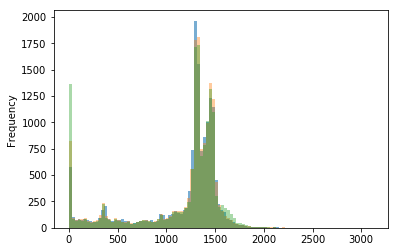

In [29]:
df_ts_features.n_peaks_diesel.plot(kind='hist', bins=100, alpha=.6)
df_ts_features.n_peaks_e5.plot(kind='hist', bins=100,alpha=.4)
df_ts_features.n_peaks_e10.plot(kind='hist', bins=100, alpha=.4)
#plt.xlim([10,250])

In [30]:
df_ts_features.n_peaks_e5.value_counts()

0.0       309
1308.0     98
1309.0     96
1311.0     88
1307.0     80
         ... 
2222.0      1
431.0       1
634.0       1
1742.0      1
404.0       1
Name: n_peaks_e5, Length: 1722, dtype: int64

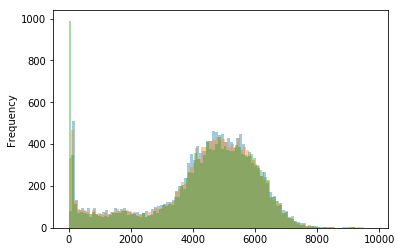

In [31]:
df_ts_features.changes_diesel.plot(kind='hist', bins=100, alpha=.4)
df_ts_features.changes_e5.plot(kind='hist', bins=100,alpha=.4)
df_ts_features.changes_e10.plot(kind='hist', bins=100, alpha=.4)

## Skeness

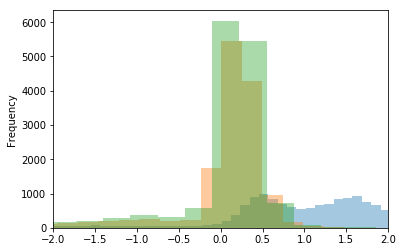

In [32]:
df_ts_features.skewness_diesel.plot(kind='hist', bins=200, alpha=.4)
df_ts_features.skewness_e5.plot(kind='hist', bins=200,alpha=.4)
df_ts_features.skewness_e10.plot(kind='hist', bins=200, alpha=.4)
plt.xlim([-2, 2]);

## Kurtosis


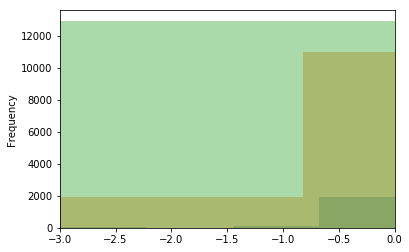

In [33]:
df_ts_features.kurtosis_diesel.plot(kind='hist', alpha=.4, bins=500)
df_ts_features.kurtosis_e5.plot(kind='hist',  alpha=.4, bins=500)
df_ts_features.kurtosis_e10.plot(kind='hist', alpha=.4, bins=500)
plt.xlim([-3, 0]);

## Mean

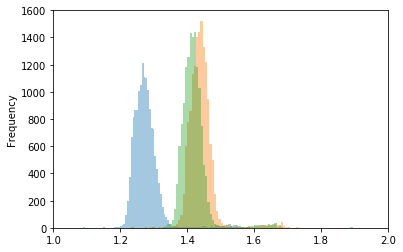

In [34]:
df_ts_features.mean_diesel.plot(kind='hist', alpha=.4, bins=300)
df_ts_features.mean_e5.plot(kind='hist',  alpha=.4, bins=300)
df_ts_features.mean_e10.plot(kind='hist', alpha=.4, bins=300)
plt.xlim([1, 2]);

## Median

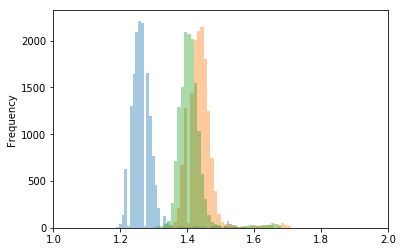

In [35]:
df_ts_features.median_diesel.plot(kind='hist', alpha=.4, bins=200)
df_ts_features.median_e5.plot(kind='hist',  alpha=.4, bins=200)
df_ts_features.median_e10.plot(kind='hist', alpha=.4, bins=200)
plt.xlim([1, 2]);

# Variance

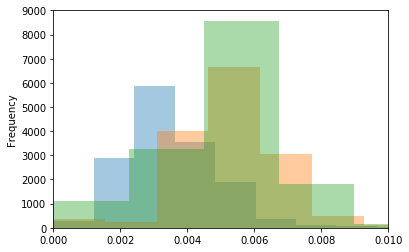

In [36]:
df_ts_features.var_diesel.plot(kind='hist', alpha=.4, bins=300)
df_ts_features.var_e5.plot(kind='hist',  alpha=.4, bins=300)
df_ts_features.var_e10.plot(kind='hist', alpha=.4, bins=300)
plt.xlim([0, 0.01]);

# MinMax

(0, 0.4)

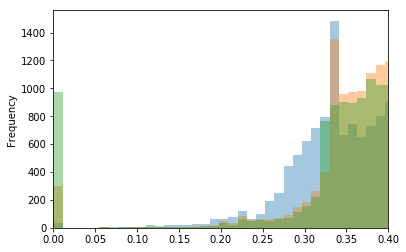

In [37]:
minmax_diesel = df_ts_features.max_diesel - df_ts_features.min_diesel
minmax_e5 = df_ts_features.max_e5 - df_ts_features.min_e5
minmax_e10 = df_ts_features.max_e10 - df_ts_features.min_e10 
minmax_diesel.plot(kind='hist', bins=200, alpha=0.4)
minmax_e5.plot(kind='hist', bins=200, alpha=0.4)
minmax_e10.plot(kind='hist', bins=200, alpha=0.4)
plt.xlim([0,0.4])

# Take aways:

- There are outliers in the data set! (min_max -> zero price present)
    - Find a way to get rid of them
    - There are many stations without any peaks
  


In [38]:
df_ts_features[df_ts_features.changes_e5 == 0]

,changes_diesel,changes_e5,changes_e10,skewness_diesel,skewness_e5,skewness_e10,kurtosis_diesel,kurtosis_e5,kurtosis_e10,var_diesel,...,median_e10,n_peaks_diesel,n_peaks_e5,n_peaks_e10,min_diesel,min_e5,min_e10,max_diesel,max_e5,max_e10
00060280-0004-4444-8888-acdcffffffff,6393.0,0.0,11.0,0.463106,0.0,-3.319638,0.216182,-3.0,9.019995,0.002903,...,0.000,1295.0,0.0,0.0,1.129,0.0,-0.001,1.469,0.0,0.000
00060595-0001-4444-8888-acdc00000001,844.0,0.0,766.0,1.832912,0.0,0.440446,4.161604,-3.0,-0.549741,0.003530,...,1.389,276.0,0.0,244.0,1.189,0.0,1.269,1.539,0.0,1.589
00060695-0003-4444-8888-acdc00000003,442.0,0.0,0.0,1.145180,0.0,0.000000,1.519066,-3.0,-3.000000,0.001789,...,0.000,106.0,0.0,0.0,1.149,0.0,0.000,1.399,0.0,0.000
00060712-0006-4444-8888-acdcffffffff,6343.0,0.0,0.0,0.636458,0.0,0.000000,0.304225,-3.0,-3.000000,0.002359,...,0.000,1475.0,0.0,0.0,1.159,0.0,0.000,1.449,0.0,0.000
00060821-4ff8-392e-8ddc-d5f700060821,4709.0,0.0,0.0,0.423010,0.0,0.000000,-0.023681,-3.0,-3.000000,0.002548,...,0.000,1434.0,0.0,0.0,1.128,0.0,0.000,1.409,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f288bc90-7815-4a0e-8442-6c77de7c96bc,5646.0,0.0,0.0,0.659417,0.0,0.000000,0.272865,-3.0,-3.000000,0.002744,...,0.000,1439.0,0.0,0.0,1.139,0.0,0.000,1.449,0.0,0.000
f29119d8-966f-47ac-8f01-2946847fee0e,7279.0,0.0,0.0,0.475318,0.0,0.000000,0.264784,-3.0,-3.000000,0.002169,...,0.000,1510.0,0.0,0.0,1.149,0.0,0.000,1.459,0.0,0.000
f748b5c7-407d-42bc-88f2-a12a23495804,109.0,0.0,0.0,1.571094,0.0,0.000000,1.307782,-3.0,-3.000000,0.005149,...,0.000,2.0,0.0,0.0,1.209,0.0,0.000,1.499,0.0,0.000
fe2cb4f1-42a6-4f25-bbec-63f93a440245,3931.0,0.0,0.0,0.662735,0.0,0.000000,0.056159,-3.0,-3.000000,0.002097,...,0.000,1070.0,0.0,0.0,1.159,0.0,0.000,1.394,0.0,0.000


In [33]:
df_anormal = df[df.station_uuid == '00060280-0004-4444-8888-acdcffffffff']

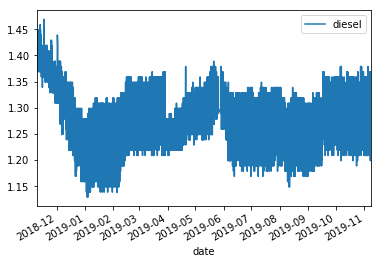

In [34]:
df_anormal.plot(x='date', y='diesel')

## Joining df_ts_features and df_station on uuid

In [39]:
df.head()

,date,station_uuid,diesel,e5,e10,dieselchange,e5change,e10change
0,2018-11-09 00:01:06+01:00,15c58984-d4f7-451f-bd86-86357da547b3,1.529,1.629,1.609,1,1,1
1,2018-11-09 00:01:06+01:00,1796b9cd-b159-429f-9bea-c209e61c822b,1.529,1.599,1.579,1,1,1
2,2018-11-09 00:01:06+01:00,7fa4a726-3da5-4aca-afdb-161fbbac23b0,1.519,1.639,1.619,1,1,1
3,2018-11-09 00:01:06+01:00,e8c7a351-f2a3-4118-831e-8f23f8778edc,1.519,1.629,1.609,1,1,1
4,2018-11-09 00:01:06+01:00,f690816b-9156-42ac-9fca-c4299bb036f6,1.519,1.619,1.599,1,1,1


In [40]:
df = df_ts_features.join(df_stations.set_index('uuid').loc[:, ['latitude', 'longitude', 'neighbors_3km', 'neighbors_5km']])

In [41]:
df.dropna(axis=0, inplace=True)

## Save the created data in pickle

In [42]:
df.to_pickle('./data/feature_matrix_over_year.pkl')